In [1]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model

In [2]:
g1 = nx.read_graphml('./data/daily/2019-12-31.graphml.bz2')
g2 = nx.read_graphml('./data/daily/2020-01-01.graphml.bz2')

In [3]:
g1.number_of_nodes()

346181

In [4]:
g2.number_of_nodes()

299410

In [5]:
g_newlinks = g2.copy()
g_newlinks.number_of_nodes()

299410

In [6]:
g_newlinks.remove_nodes_from(n for n in g2 if n not in g1)

In [7]:
g_newlinks.number_of_nodes()

43417

In [8]:
g_newlinks.number_of_edges()

46496

In [9]:
g_oldlinks = g_newlinks.copy()
g_oldlinks.remove_edges_from(e for e in g2.edges if e not in g1.edges)

In [10]:
g_oldlinks.number_of_nodes()

43417

In [11]:
g_oldlinks.number_of_edges()

15970

In [12]:
g_oldlinks = StellarGraph.from_networkx(g_oldlinks,edge_weight_attr="n_tx" and "value")
print(g_oldlinks.info())

StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 15970

 Node types:
  default: [43417]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [15970]
        Weights: range=[0.118113, 8.1195e+10], mean=1.34664e+08, std=1.51265e+09
        Features: none


In [13]:
g_newlinks = StellarGraph.from_networkx(g_newlinks,edge_weight_attr="n_tx" and "value")
print(g_newlinks.info())

StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 46496

 Node types:
  default: [43417]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [46496]
        Weights: range=[0.0277202, 8.1195e+10], mean=6.29534e+07, std=9.23765e+08
        Features: none


## test graph

In [14]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(g_newlinks)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)
#graph_test = StellarGraph.from_networkx(graph_test)
print(graph_test.info())

** Sampled 4649 positive and 4649 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 41847

 Node types:
  default: [43417]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [41847]
        Weights: range=[0.0277202, 8.1195e+10], mean=6.4662e+07, std=9.58415e+08
        Features: none


## train graph

In [15]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, g_newlinks)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 4184 positive and 4184 negative edges. **
StellarDiGraph: Directed multigraph
 Nodes: 43417, Edges: 37663

 Node types:
  default: [43417]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [37663]
        Weights: range=[0.0277202, 8.1195e+10], mean=6.64604e+07, std=9.92366e+08
        Features: none


In [16]:
df1 = pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")
display(df1)

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,6276,Train Graph,Test Graph,Train the Link Classifier
Model Selection,2092,Train Graph,Test Graph,Select the best Link Classifier model
Test set,9298,Test Graph,Full Graph,Evaluate the best Link Classifier


In [17]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 10
walk_length = 100
window_size = 2
num_epochs = 1
workers = multiprocessing.cpu_count()

In [18]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec


def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=num_epochs,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [19]:
embedding_train = node2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 434170


In [20]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [21]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2]

In [22]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

df2=pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")
display(df2)

Best result from 'operator_l2'


,ROC AUC score
name,
operator_hadamard,0.704681
operator_l1,0.798654
operator_l2,0.802935


In [23]:
embedding_test = node2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 434170


In [24]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.7247743635938055


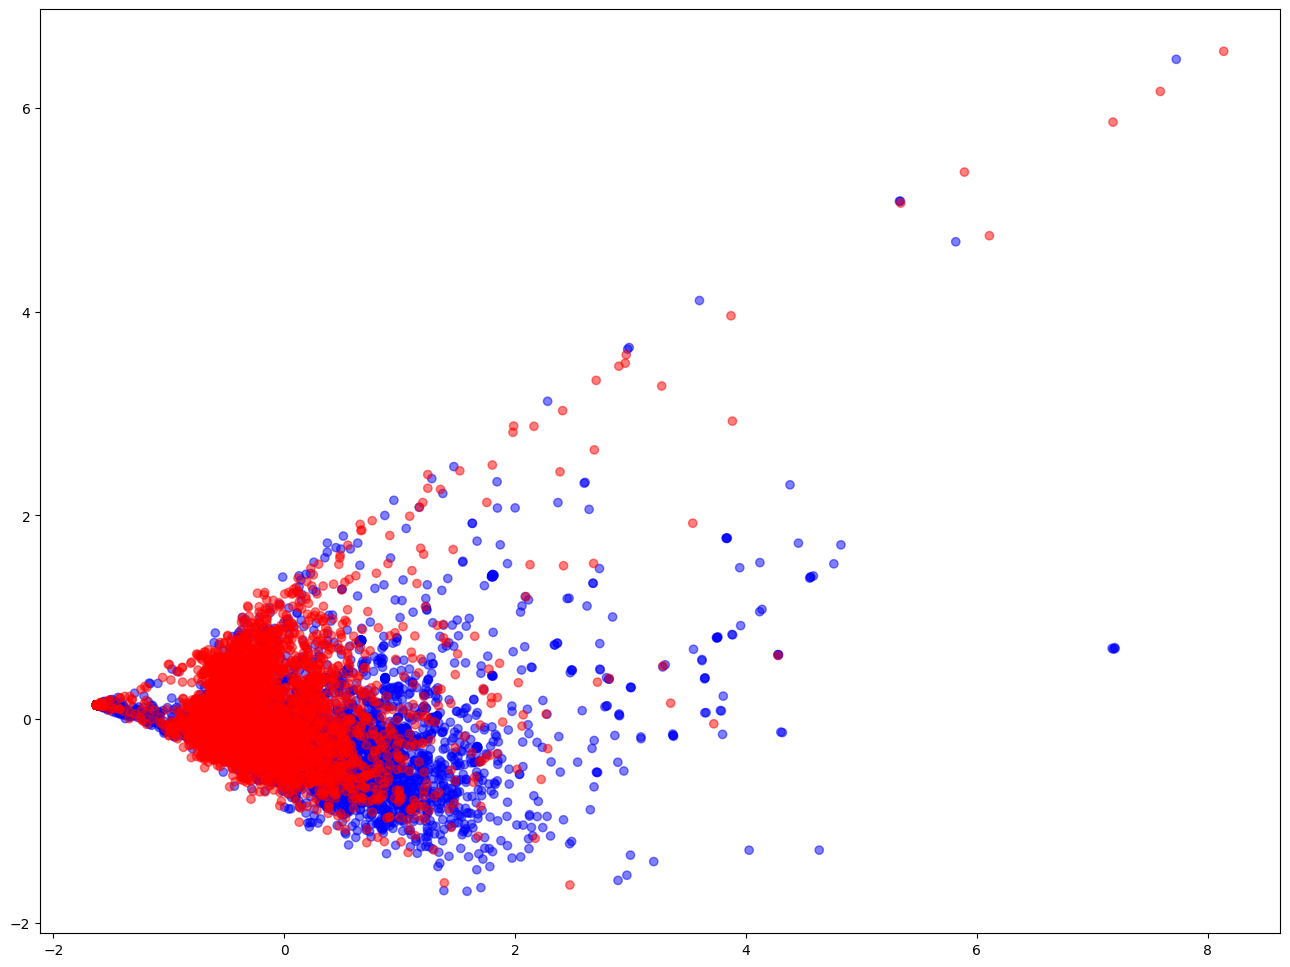

In [25]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)
plt.show()